# 1D: Morphological Drainge for Assessing Image Resolution

**Author Contact:** <br>
Email: 
* [bcchang@utexas.edu](mailto:bcchang@utexas.edu) 
* [jamesmcclure@lbpm-sim.org](mailto:jamesmcclure@lbpm-sim.org)

Two key factors will always be required to generate good simulations
* pore space is connected
* image resolution is sufficient to capture rock microstructure

Morphological analysis provides a quick and easy (cheap!) way to verify that images are worth additional effort

(it is also a great way to initialize oil-water configurations)
______

## 0. Import some packages

In [ ]:
# Import DPM Tools. Pip install if it's not already installed.
try:
    from dpm_tools.io import read_image
    from dpm_tools.metrics import morph_drain
except ModuleNotFoundError:
    !pip install --user -r ../requirements.txt
    from dpm_tools.io import read_image
    from dpm_tools.metrics import morph_drain

# Utility packages
from pathlib import Path

# Image visualization
import matplotlib.pyplot as plt

[13:28:58] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=662682;file://c:\ProgramData\anaconda3\envs\agu24_workshop\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=500127;file://c:\ProgramData\anaconda3\envs\agu24_workshop\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

### 0.1 We will continue evaluating the same glass bead pack and Mt. Gambier limestone images.

To speed up the simulation, we will perform morphological drainage on a $256^3$ subset of the image.

The simulation assumes the pore space is labeled 1, and the grain phase is labeled 0.

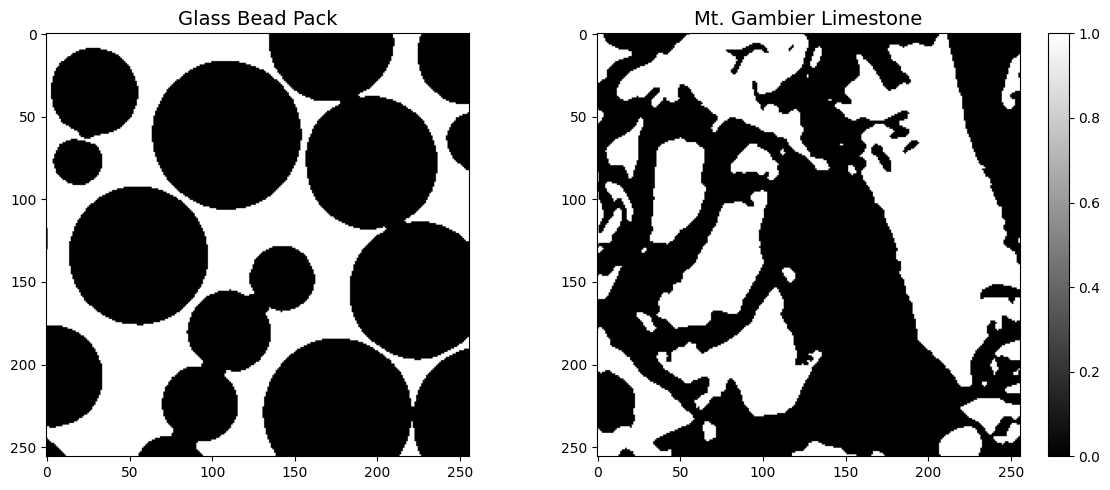

In [ ]:
image_path = Path('../data')
beadpack, gambier = [read_image(image_path / (tif_img + '.tif'))[:256, :256, :256] for tif_img in ['beadpack', 'mtgambier']]


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = ax.flatten()

im = ax[0].imshow(beadpack[100,:,:], cmap='gray', interpolation=None)
ax[0].set_title('Glass Bead Pack',fontsize=14)

im2 = ax[1].imshow(gambier[100,:,:], cmap='gray', interpolation=None)
ax[1].set_title('Mt. Gambier Limestone',fontsize=14)

plt.colorbar(im2)
plt.tight_layout()
plt.show()

### 0.2 Define some functions for results visualization

We are mainly interested in:
* The resulting configurations of the morphological drainage simulation
* The mercury injection curve
* The invasion radius vs. saturation curve.

In [3]:
def plot_morph_image(img) :
    plt.figure()
    plt.imshow(img[100], cmap='hot', extent=[0, 256, 0, 256])
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('square')

## 1. Running morphological drainage with DPM Tools

The morphological drainage simulation demonstrated here was originally proposed in Hilpert and Miller (2001) [[1]](#1) and has been widely used, such as in the LBPM software [[2]](#2). The algorithm estimates the multiphase fluid configurations for a given porous medium. Morphological drainage is a useful pre-processing tool for computational SCAL workflows, such as in multiphase lattice Boltzmann simulations.

In this case, we use morphological drainage simulations to assess whether the image resolution is sufficient to capture rock microstructure.

The algorithm operates as follows:
    
1. The Euclidean distance transform is applied to the input binary image. The maximum value of the distance transform is interpreted as the radius for the largest sphere that can be inserted into the pore space.
2. Perform morphological erosion for the pore space with the specified sphere radius.
3. Label the eroded pore space, and leave only the pore space that is still connected with the non-wetting phase.
4. Perform morphological dilation for the labelled pore space with specified radius.
5. Compute the wetting phase saturation of the result of step 4.
6. Decrease the sphere radius. This smaller sphere covers a larger fraction of the pore space (i.e. more non-wetting phase can invade the pore space).
7. Repeat steps 2-5 until a target saturation is achieved. 


**Inputs:**
* a digital rock image
* a target wetting phase saturation value (i.e. how much oil to inject using a drainage process)

**Outputs:**
* a digital rock image with estimated oil configuration at target wetting phase saturation
* a list of the water saturation `Sw` and radii `r`


This algorithm has been wrapped in a convenient function, ``morph_drain`` in the DPM Tools package.



### 1.1 Mercury Injection Curve

The radius of morphological opening is decreased to decrease the water saturation. 

We can use the radius steps to provide a fair approximation of oil drainage under water wet conditions, though it may miss irreducible water saturation.

Here we define a function to compute and plot the curvature ($1/r$) vs. water saturation. Note how curvature relates to the capillary pressure curve:

$$ P_c = P_{nw} - P_w = \frac{2\sigma\cos\theta}{r}$$


In [4]:
def plot_curvature(sw, radii):

    pc = 1 / radii

    plt.figure()
    plt.plot(sw, pc)
    plt.xlabel('Water Saturation')
    plt.ylabel('Curvature')

### 1.2 Morphological Drainage as Image Quality Control
* The morphological opening tells us how large the flow channels are likely to be
* Under-resolved flow channels will lead to "bad" simulation results
* It will be clear if the porespace is not well-connected
* **Rule of thumb:** 5 - 10 voxels across a pore-throat will ensure scale separation between water films and flow channels

For multiphase simulations, we should focus on the saturation value where the drainage curve crosses the 5-10 voxel threshold. The saturation at this point should be less than ~0.3 because we want to ensure that we are adequately resolving flow behaviors where relative permeability crossover occurs.

In [5]:
def plot_morphdrain_curve(sw, radii):
    plt.figure()
    plt.plot(sw, radii)
    plt.axhline(y=5,color='r',linestyle='dashed')
    plt.xlabel('Water Saturation')
    plt.ylabel('Radius (Voxels)')

## 2. Glass Bead Pack Sample
### 2.1 Morphological Drainage Simulation

This image is fairly homogeneous and well-resolved

We will try to perform morphological drainage using DPM Tools with a target saturation `Sw = 0.05`.

Because this process is written in Python, it may take a little bit of time to run. In our tests, the process completed in about 2 minutes. In case it takes too long, we also provide the results in ``../data/morphdrain/beadpack`` directory.


38.118565 0.9777153003018055
36.212635 0.9745322387719559
34.402004 0.9670682023236599
32.681904 0.9590884439050785
31.04781 0.9358879602192028
29.495419 0.9323186909597192
28.020647 0.929090174912718
26.619616 0.9258014160638754
25.288635 0.9216759516339031
24.024204 0.9134886902312016
22.822994 0.8960192116941397
21.681845 0.8907933432170964
20.597752 0.8853249468711414
19.567863 0.8809311139905891
18.58947 0.8729630305336049
17.659996 0.8517774895532444
16.776997 0.8445382350322322
15.938147 0.8253568957927174
15.141239 0.8197077710412385
14.384177 0.8106582748080481
13.6649685 0.7985416883302066
12.98172 0.7364895787736122
12.332634 0.7303488603058155
11.716002 0.7197465941802029
11.130202 0.6589734377500388
10.573692 0.3739004521167795
10.045008 0.3378635816540587
9.542757 0.26730805273471187
9.065619 0.24850731724326447
8.612338 0.23502055727238028
8.181721 0.20557568145972513
7.7726345 0.1487835312680378
7.3840027 0.1395312020353661
7.0148025 0.12434814797749191
6.6640625 0.0978

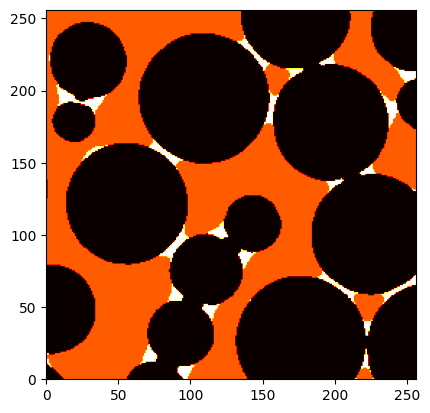

In [6]:
bp_radii, bp_sw, bp_configs = morph_drain(beadpack, target_saturation=0.05)

# Uncomment the lines below if the simulation takes too long
# M = pd.read_csv("../data/morphdrain/beadpack/morphdrain.csv", sep=" ")
# bp_radii = M['radius']
# bp_sw = M['sw']
# bp_configs = read_image('../data/morphdrain/beadpack/segmented_bead_pack_256_morphdrain.tif')

plot_morph_image(bp_configs)

### 2.2 Mercury Injection Curve

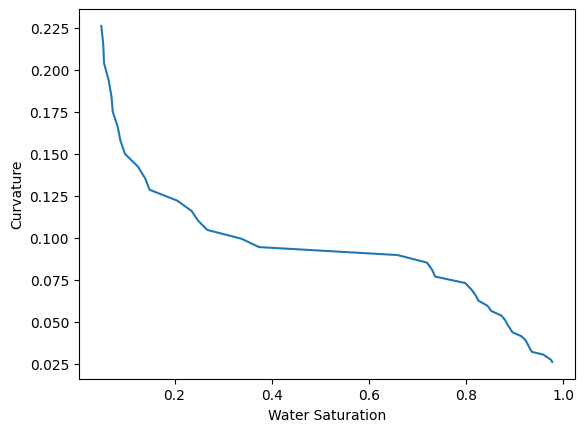

In [7]:
plot_curvature(bp_sw, bp_radii)

### 2.3 Morphological Drainage as Image Quality Control

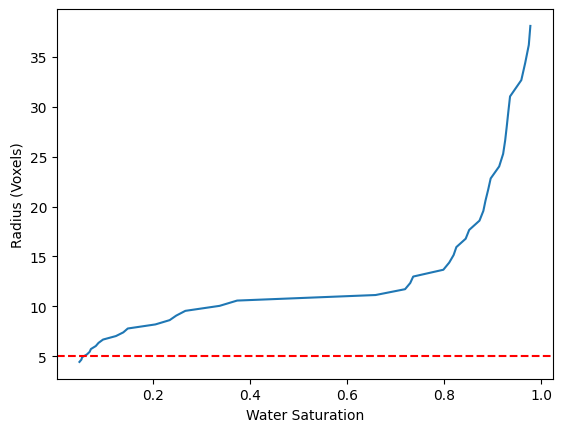

In [8]:
plot_morphdrain_curve(bp_sw, bp_radii)

## 3. Mt. Gambier Limestone
### 3.1 Morphological Drainage Simulation

Next, we will perform the morphological drainage simulation on the Mt. Gambier limestone sample. We previously determined that this image is fairly heterogeneous, but we want to evaluate its resolution.

We will try to perform morphological drainage using DPM Tools with a target saturation `Sw = 0.1`.

Because this is a more complex sample, it may take a little bit longer to run. In our tests, the process completed in about 2 minutes. In case it takes too long, we also provide the results in the ``../data/gambier_morphdrain.csv`` files.

47.86907 1.0
45.475616 1.0
43.201836 1.0
41.041744 1.0
38.98966 1.0
37.040176 1.0
35.188168 1.0
33.42876 1.0
31.757322 1.0
30.169456 1.0
28.660984 1.0
27.227936 1.0
25.866539 1.0
24.573212 1.0
23.344551 1.0
22.177324 1.0
21.068459 1.0
20.015036 1.0
19.014284 0.998967473887127
18.06357 0.9957795302596641
17.16039 0.9939892963342243
16.302372 0.9922574661110913
15.487253 0.9895882243759854
14.712891 0.988143920071902
13.977246 0.9873521969162332
13.278384 0.9837089611303466
12.614465 0.980123743967411
11.983742 0.9698452058005274
11.384555 0.9668041057674363
10.815327 0.963575343728251
10.27456 0.9151163157866362
9.760832 0.8973348914499804
9.27279 0.8885319773747908
8.809151 0.8736068149804085
8.368693 0.8637019321485041
7.9502587 0.8543691488796373
7.552746 0.8488607170537014
7.1751084 0.8441328410821141
6.816353 0.33170491831054905
6.4755354 0.31140404810822064
6.1517587 0.2852964379389423
5.8441706 0.2785725673060952
5.551962 0.2557742007613789
5.274364 0.23822497927631267
5.010646 0

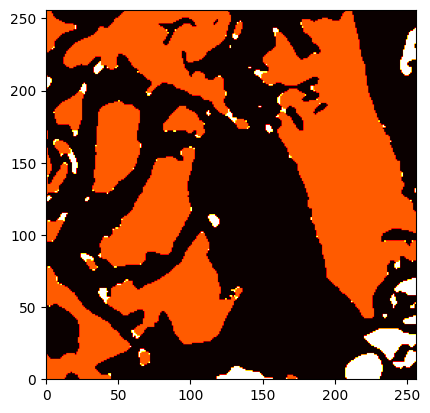

In [ ]:
gambier_radii, gambier_sw, gambier_configs = morph_drain(gambier, target_saturation=0.1)

# Uncomment the lines below if the simulation takes too long
# M = pd.read_csv("../data/morphdrain/beadpack/morphdrain.csv", sep=" ")
# gambier_radii = M['radius']
# gambier_sw = M['sw']
# gambier_configs = read_image('../data/morphdrain/gambier/segmented_Gambier_256_morphdrain30.tif')

plot_morph_image(gambier_configs)

### 3.2 Mercury Injection Curve

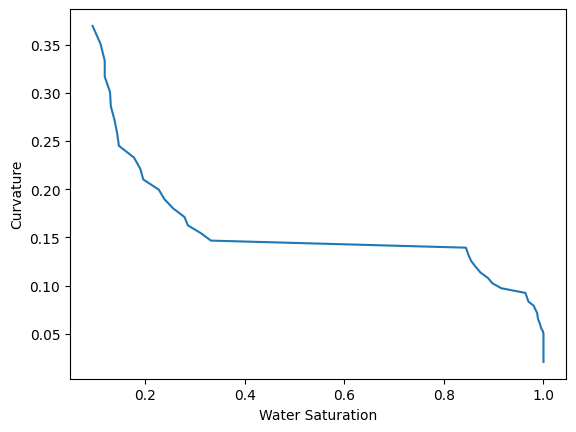

In [10]:
plot_curvature(gambier_sw, gambier_radii)

### 3.3 Resolution quality control check

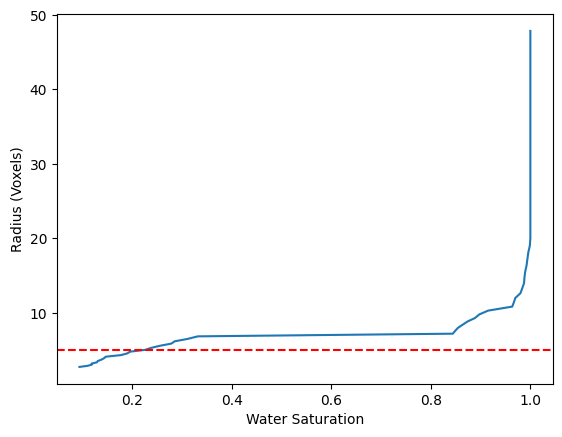

In [11]:
plot_morphdrain_curve(gambier_sw, gambier_radii)

## 4. One last example: Castlegate Sandstone

Here we introduce a sample image of a Castlegate sandstone. From visual observation, we can see the sample is fairly homogeneous.

One might assume that the image is fairly well-resolved. However, we should still evaluate it to be sure.

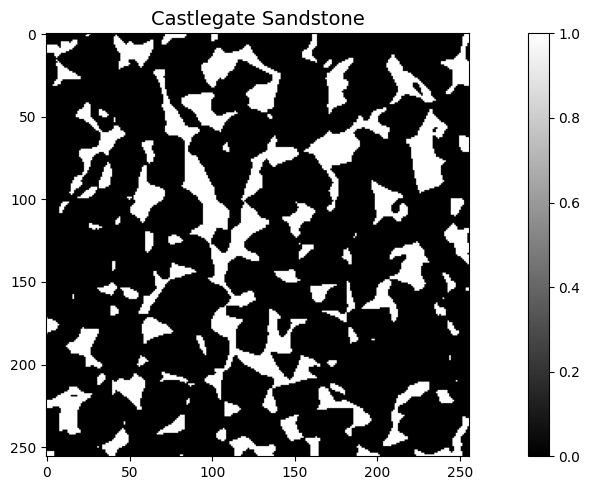

In [ ]:
castlegate = read_image(image_path / "castlegate.tif")[:256, :256, :256]

fig, ax = plt.subplots(figsize=(12,5))

im = ax.imshow(castlegate[100,:,:], cmap='gray', interpolation=None)
ax.set_title('Castlegate Sandstone',fontsize=14)

plt.colorbar(im)
plt.tight_layout()
plt.show()

### 4.1 Morphological Drainage Simulation

13.3 1.0
12.635 1.0
12.00325 1.0
11.403088 0.9993467234886375
10.832933 0.9981576897767007
10.291286 0.9981121416069948
9.776722 0.9980643286111709
9.287886 0.9980323693981727
8.823491 0.9968123830626237
8.382317 0.9966998966987642
7.9632006 0.9955888736642244
7.5650406 0.9952360640845133
7.1867886 0.9945644173168605
6.8274493 0.9909313845762825
6.486077 0.9877374764552451
6.161773 0.9856817692821633
5.8536844 0.9847018545151196
5.5610003 0.9825608388915941
5.2829504 0.9777906117924463
5.0188026 0.973980167672627
4.7678623 0.9648139130784901
4.529469 0.9464967543783492
4.3029957 0.9444994293896419
4.087846 0.9385847101588776
3.8834536 0.9345792393455659
3.689281 0.9324596137464879
3.504817 0.9226048520124868
3.3295763 0.9207660648520376
3.1630974 0.914643233265766
3.0049424 0.9026595349808685
2.8546953 0.8704358406216696
2.7119606 0.8446518018579123
2.5763626 0.8446518018579123
2.4475446 0.42599315770865026
2.3251674 0.42599315770865026
2.208909 0.21891557608997902
2.0984635 0.21891557

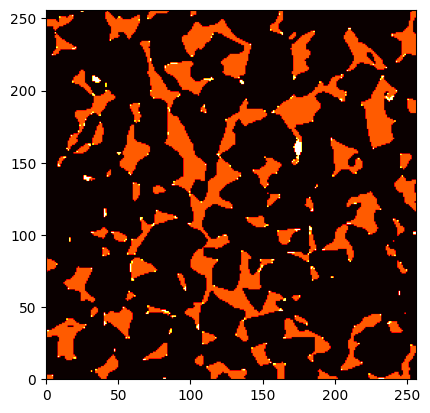

In [13]:
castlegate_radii, castlegate_sw, castlegate_configs = morph_drain(castlegate, target_saturation=0.05)

# Uncomment the lines below if the simulation takes too long
# M = pd.read_csv("../data/morphdrain/castlegate/morphdrain.csv", sep=" ")
# castlegate_radii = M['radius']
# castlegate_sw = M['sw']
# castlegate_configs = read_image('../data/morphdrain/castlegate/segmented_castle_256_morphdrain5.tif')

plot_morph_image(castlegate_configs)

### 4.2 Mercury Injection Curve

**Note:** The irreducible water saturation is very clear for this image

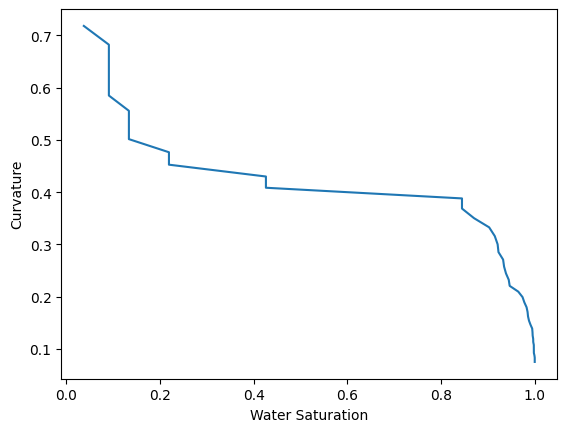

In [14]:
plot_curvature(castlegate_sw, castlegate_radii)

### 4.3 Resolution quality control check

Morphological radius clearly shows that the flow pathways will break my rule of thumb!

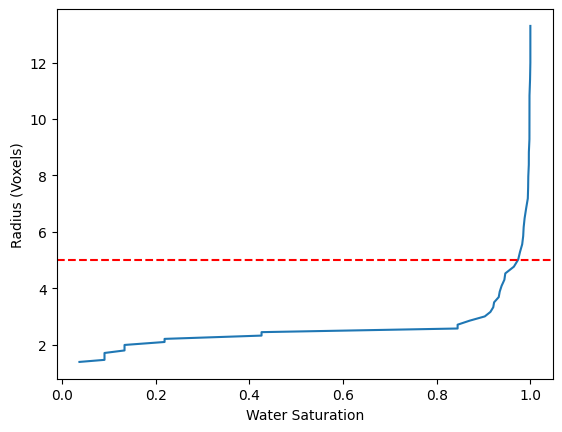

In [15]:
plot_morphdrain_curve(castlegate_sw, castlegate_radii)

# References
<a id="1">[1]</a> 
Hilpert, M. and Miller, C. T. (2001). 
Pore-morphology-based simulation of drainage in totally wetting porous media.
Advances in Water Resources, Volume 24, doi: [10.1016/S0309-1708(00)00056-7](https://doi.org/10.1016/S0309-1708(00)00056-7)

<a id="2">[2]</a> 
McClure, J.E., Li, Z., Berrill, M., and Ramstad, T. (2021). The LBPM software package for simulating
multiphase flow on digital images of porous rocks. Computational Geosciences, Volume 25, Pages 871–895, doi: [10.1007/s10596-020-10028-9](https://doi.org/10.1007/s10596-020-10028-9)
